<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/images/IDSN-logo.png" width="300" alt="cognitiveclass.ai logo">

<h1 align="center"><font size="5">RESTRICTED BOLTZMANN MACHINES</font></h1>


Estimated time needed: **25** minutes


<h3>Introduction</h3>
<b>Restricted Boltzmann Machine (RBM):</b>  RBMs are shallow neural nets that learn to reconstruct data by themselves in an unsupervised fashion.  


<h4>Why are RBMs important?</h4>
An RBM are a basic form of autoencoder.  It can automatically extract <b>meaningful</b> features from a given input.


<h4>How does it work?</h4>
RBM is a 2 layer neural network. Simply, RBM takes the inputs and translates those into a set of binary values that represents them in the hidden layer. Then, these numbers can be translated back to reconstruct the inputs. Through several forward and backward passes, the RBM will be trained, and a trained RBM can reveal which features are the most important ones when detecting patterns.   


<h4>What are the applications of an RBM?</h4>
RBM is useful for <a href='http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf'>  Collaborative Filtering</a>, dimensionality reduction, classification, regression, feature learning, topic modeling and even <b>Deep Belief Networks</b>.

<h4>Is RBM a generative or Discriminative model?</h4>
RBM is a generative model. Let me explain it by first, see what is different between discriminative and generative models: 

<b>Discriminative:</b> Consider a classification problem where we want to learn to distinguish between Sedan cars (y = 1) and SUV cars (y = 0), based on some features of cars. Given a training set, an algorithm like logistic regression tries to find a straight line, or <i>decision boundary</i>, that separates the suv and sedan.  

<b>Generative:</b> looking at cars, we can build a model of what Sedan cars look like. Then, looking at SUVs, we can build a separate model of what SUV cars look like. Finally, to classify a new car, we can match the new car against the Sedan model, and match it against the SUV model, to see whether the new car looks more like the SUV or Sedan. 

Generative Models specify a probability distribution over a dataset of input vectors. We can carry out both supervised and unsupervised tasks with generative models:
<ul>
    <li>In an unsupervised task, we try to form a model for $P(x)$, where $P$ is the probability given $x$ as an input vector.</li>
    <li>In the supervised task, we first form a model for $P(x|y)$, where $P$ is the probability of $x$ given $y$(the label for $x$). For example, if $y = 0$ indicates that a car is an SUV, and $y = 1$ indicates that a car is a sedan, then $p(x|y = 0)$ models the distribution of SUV features, and $p(x|y = 1)$ models the distribution of sedan features. If we manage to find $P(x|y)$ and $P(y)$, then we can use <b>Bayes rule</b> to estimate $P(y|x)$, because:   
        $$p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$</li>
</ul>
Now the question is, can we build a generative model, and then use it to create synthetic data by directly sampling from the modeled probability distributions? Lets see. 


<h2>Table of Contents</h2>
<ol>
    <li><a href="#ref1">Initialization</a></li>
    <li><a href="#ref2">RBM layers</a></li>
    <li><a href="#ref3">What RBM can do after training?</a></li>
    <li><a href="#ref4">How to train the model?</a></li>
    <li><a href="#ref5">Learned features</a></li>
</ol>
<p></p>
</div>
<br>

<hr>


<a id="ref1"></a>
<h3>Initialization</h3>

First, we have to load the utility file which contains different utility functions that are not connected
in any way to the networks presented in the tutorials, but rather help in
processing the outputs into a more understandable way.


In [1]:
import urllib.request
with urllib.request.urlopen("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week4/data/utils.py") as url:
    response = url.read()
target = open('utils.py', 'w')
target.write(response.decode('utf-8'))
target.close()

<h2>Installing TensorFlow </h2>

We will installing TensorFlow version 2.9.0 and its required prerequistes.  Also installing pillow...


In [1]:
!pip install grpcio==1.24.3
!pip install tensorflow==2.9.0
!pip install pillow==8.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.7 MB/s eta 0:00:0000:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.48.1
    Uninstalling grpcio-1.48.1:
      Successfully uninstalled grpcio-1.48.1


**Restart kernel for latest version of TensorFlow to be activated, then continue to the next section.**


<b>Notice:</b> This notebook has been created with TensorFlow version 2.9.0, and might not work with other versions. Therefore we check:


In [3]:
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if not tf.__version__ == '2.9.0':
    printmd('<<<<<!!!!! ERROR !!!! please upgrade to TensorFlow 2.9.0, or restart your Kernel (Kernel->Restart & Clear Output)>>>>>')

Now, we load in all the packages that we use to create the net including the TensorFlow package:


In [4]:
import tensorflow as tf
import numpy as np

from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

<hr>


<a id="ref2"></a>
<h3>RBM layers</h3>

An RBM has two layers. The first layer of the RBM is called the <b>visible</b> (or input layer). Imagine that our toy example, has only vectors with 7 values, so the visible layer must have $V=7$ input nodes. 
The second layer is the <b>hidden</b> layer, which has $H$ neurons in our case. Each hidden node takes on values of either 0 or 1 (i.e., $h_i = 1$ or $h_i$ = 0), with a probability that is a logistic function of the inputs it receives from the other $V$ visible units, called for example, $p(h_i = 1)$. For our toy sample, we'll use 2 nodes in the hidden layer, so $H = 2$.

<center><img src="https://ibm.box.com/shared/static/eu26opvcefgls6vnwuo29uwp0nudmokh.png" alt="RBM Model" style="width: 400px;"></center>


     

Each node in the first layer also has a <b>bias</b>. We will denote the bias as $v_{bias}$, and this single value is shared among the $V$ visible units.

The <b>bias</b> of the second is defined similarly as $h_{bias}$, and this single value among the $H$ hidden units.


In [6]:
v_bias = tf.Variable(tf.zeros([7]), tf.float32)
h_bias = tf.Variable(tf.zeros([2]), tf.float32)

We have to define weights among the input layer and hidden layer nodes. In the weight matrix, the number of rows are equal to the input nodes, and the number of columns are equal to the output nodes. We define a tensor $\mathbf{W}$ of shape = (7,2), where the number of visible neurons = 7, and the number of hidden neurons = 2. 


In [7]:
W = tf.constant(np.random.normal(loc=0.0, scale=1.0, size=(7, 2)).astype(np.float32))

<hr>


<a id="ref3"></a>
<h3>What RBM can do after training?</h3>
Think of RBM as a model that has been trained based on images of a dataset of many SUV and sedan cars. Also, imagine that the RBM network has only two hidden nodes, where one node encodes the weight and, and the other encodes the size.  
In a sense, the different configurations represent different cars, where one is an SUV and the other is Sedan.  In a training process, through many forward and backward passes, the RBM adjust its weights to send a stronger signal to either the SUV node (0, 1) or the sedan node (1, 0) in the hidden layer, given the pixels of images. Now, given an SUV in hidden layer, which distribution of pixels should we expect? RBM can give you 2 things. First, it encodes your images in hidden layer. Second, it gives you the probability of observing a case, given some hidden values.


<h3>The Inference Process</h3>

RBM has two phases:
<ul>
    <li>Forward Pass</li>  
    <li>Backward Pass or Reconstruction</li>
</ul>

<b>Phase 1) Forward pass:</b>  

Input one training sample (one image) $\mathbf{x}$ through all visible nodes, and pass it to all hidden nodes. Processing happens in each node in the hidden layer. This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer).  First, the probability vector is computed using the input feature vector $\mathbf{x}$, the weight matrix $\mathbf{W}$, and the bias term $h_{bias}$, as 


$$p({h_j}|\mathbf x)= \sigma( \sum_{i=1}^V W_{ij} x_i + h_{bias} )$$, 

where $\sigma(z) = (1+e^{-z})^{-1}$ is the logistic function.


So, what does $p({h_j})$ represent? It is the <b>probability distribution</b> of the hidden units. That is, RBM uses inputs $x_i$ to make predictions about hidden node activations. For example, imagine that the hidden node activation values are [0.51 0.84] for the first training item. It tells you that the conditional probability for each hidden neuron for Phase 1 is: 

$$p(h_{1} = 1|\mathbf{v}) = 0.51$$
$$p(h_{2} = 1|\mathbf{v}) = 0.84$$

As a result, for each row in the training set, vector of probabilities is generated.  In TensorFlow, this is referred to as a `tensor` with a shape of (1,2). 

We then turn unit $j$ with probability $p(h_{j}|\mathbf{v})$, and turn it off with probability $1 - p(h_{j}|\mathbf{v})$ by generating a uniform random number vector $\mathbf{\xi}$, and comparing it to the activation probability as 

<center>If $\xi_j>p(h_{j}|\mathbf{v})$, then $h_j=1$, else $h_j=0$.</center>


Therefore, the conditional probability of a configuration of $\mathbf{h}$ given $\mathbf{v}$ (for a training sample) is:

$$p(\mathbf{h} \mid \mathbf{v}) = \prod_{j=1}^H p(h_j \mid \mathbf{v})$$


where $H$ is the number of hidden units.



Before we go further, let's look at a toy example for one case out of all input. Assume that we have a trained RBM, and a very simple input vector, such as [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0].   
Let's see what the output of forward pass would look like:


In [8]:
X = tf.constant([[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], tf.float32)

v_state = X
print ("Input: ", v_state)

h_bias = tf.constant([0.1, 0.1])
print ("hb: ", h_bias)
print ("w: ", W)

# Calculate the probabilities of turning the hidden units on:
h_prob = tf.nn.sigmoid(tf.matmul(v_state, W) + h_bias)  #probabilities of the hidden units
print ("p(h|v): ", h_prob)

# Draw samples from the distribution:
h_state = tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob)))) #states
print ("h0 states:", h_state)

Input:  tf.Tensor([[1. 0. 0. 1. 0. 0. 0.]], shape=(1, 7), dtype=float32)
hb:  tf.Tensor([0.1 0.1], shape=(2,), dtype=float32)
w:  tf.Tensor(
[[-1.021621   -1.0011511 ]
 [-0.35306677  0.6100592 ]
 [ 0.14841145 -0.73896563]
 [-0.39973632  0.10372802]
 [ 0.62673354  1.9109708 ]
 [-2.0832691  -0.5252566 ]
 [-0.04556354 -0.529947  ]], shape=(7, 2), dtype=float32)
p(h|v):  tf.Tensor([[0.21059258 0.31057703]], shape=(1, 2), dtype=float32)
h0 states: tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)


<b>Phase 2) Backward Pass (Reconstruction):</b>
The RBM reconstructs data by making several forward and backward passes between the visible and hidden layers.

So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. $\mathbf h$) becomes the input in the backward pass. The same weight matrix and visible layer biases are used to passed to the sigmoid function. The reproduced output is a reconstruction which is an approximation of the original input.


In [9]:
vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1])
print ("b: ", vb)
v_prob = tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(W)) + vb)
print ("p(vi∣h): ", v_prob)
v_state = tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob))))
print ("v probability states: ", v_state)

b:  tf.Tensor([0.1 0.2 0.1 0.1 0.1 0.2 0.1], shape=(7,), dtype=float32)
p(vi∣h):  tf.Tensor(
[[0.2846277  0.46180785 0.5617855  0.42562196 0.67408806 0.13201384
  0.5136058 ]], shape=(1, 7), dtype=float32)
v probability states:  tf.Tensor([[1. 0. 1. 0. 1. 0. 1.]], shape=(1, 7), dtype=float32)


RBM learns a probability distribution over the input, and then, after being trained, the RBM can generate new samples from the learned probability distribution. As you know, <b>probability distribution</b>, is a mathematical function that provides the probabilities of occurrence of different possible outcomes in an experiment.

The (conditional) probability distribution over the visible units v is given by

$$p(\mathbf{v} \mid \mathbf{h}) = \prod_{i=1}^V p(v_i \mid \mathbf{h}),$$


where,

$$p(v_i \mid \mathbf{h}) = \sigma\left(\sum_{j=1}^H W_{ji} h_j + v_{bias} \right)$$

so, given current state of hidden units and weights, what is the probability of generating [1. 0. 0. 1. 0. 0. 0.] in reconstruction phase, based on the above <b>probability distribution</b> function?


In [10]:
inp = X
print("input X:" , inp.numpy())

print("probablity vector:" , v_prob[0].numpy())
v_probability = 1

for elm, p in zip(inp[0],v_prob[0]) :
    if elm ==1:
        v_probability *= p
    else:
        v_probability *= (1-p)

print("probability of generating X: " , v_probability.numpy())

input X: [[1. 0. 0. 1. 0. 0. 0.]]
probablity vector: [0.2846277  0.46180785 0.5617855  0.42562196 0.67408806 0.13201384
 0.5136058 ]
probability of generating X:  0.0039312146


How similar are vectors $\mathbf{x}$ and $\mathbf{v}$? Of course, the reconstructed values most likely will not look anything like the input vector, because our network has not been trained yet. Our objective is to train the model in such a way that the input vector and reconstructed vector to be same. Therefore, based on how different the input values look to the ones that we just reconstructed, the weights are adjusted. 


<hr>



<h2>MNIST</h2>


We will be using the MNIST dataset to practice the usage of RBMs. The following cell loads the MNIST dataset.


In [11]:
#loading training and test data
mnist = tf.keras.datasets.mnist
(trX, trY), (teX, teY) = mnist.load_data()

# showing an example of the Flatten class and operation
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')
trX = flatten(trX/255.0)
trY = flatten(trY/255.0)

11490434/11490434 [==============================] - 0s 0us/step


Lets look at the dimension of the images.


MNIST images have 784 pixels, so the visible layer must have 784 input nodes.  For our case, we'll use 50 nodes in the hidden layer, so i = 50.


In [12]:
vb = tf.Variable(tf.zeros([784]), tf.float32)
hb = tf.Variable(tf.zeros([50]), tf.float32)

Let $\mathbf W$ be the Tensor of 784x50 (784 - number of visible neurons, 50 - number of hidden neurons) that represents weights between the neurons. 


In [13]:
W = tf.Variable(tf.zeros([784,50]), tf.float32)

Lets define the visible layer:


In [14]:
v0_state = tf.Variable(tf.zeros([784]), tf.float32)

#testing to see if the matrix product works
tf.matmul( [v0_state], W)

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)>

Now, we can define hidden layer:


In [15]:
#computing the hidden nodes probability vector and checking shape
h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
print("h0_state shape: " , tf.shape(h0_prob))

#defining a function to return only the generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state


h0_state = hidden_layer(v0_state, W, hb)
print("first 15 hidden states: ", h0_state[0][0:15])

h0_state shape:  tf.Tensor([ 1 50], shape=(2,), dtype=int32)
first 15 hidden states:  tf.Tensor([0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.], shape=(15,), dtype=float32)


Now, we define reconstruction part:


In [16]:
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0]

v1_state = reconstructed_output(h0_state, W, vb)
print("hidden state shape: ", h0_state.shape)
print("v0 state shape:  ", v0_state.shape)
print("v1 state shape:  ", v1_state.shape)

hidden state shape:  (1, 50)
v0 state shape:   (784,)
v1 state shape:   (784,)


<h3>What is the objective function?</h3>

<b>Goal</b>: Maximize the likelihood of our data being drawn from that distribution

<b>Calculate error:</b>  
In each epoch, we compute the "error" as a sum of the squared difference between step 1 and step n,
e.g the error shows the difference between the data and its reconstruction.

<b>Note:</b> tf.reduce_mean computes the mean of elements across dimensions of a tensor.


In [17]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0_state - v1_state))
print("error" , err.numpy())

error 0.5255102


<a id="ref4"></a>
<h3>Training the Model</h3>
<b>Warning...</b> The following part is math-heavy, but you can skip it if you just want to run the cells in the next section.

As mentioned, we want to give a high probability to the input data we train on. So, in order to train an RBM, we have to maximize the product of probabilities assigned to all rows $\mathbf{v}$ (images) in the training set $\mathbf{V}$ (a matrix, where each row of it is treated as a visible vector $\mathbf{v}$)

$$\arg \max_W \prod_{\mathbf{v}\in\mathbf{V}_T} p(\mathbf{v})$$


which is equivalent to maximizing the expectation of the log probability, given as

$$\arg\max_W\left[ \mathbb{E} \left(\prod_{\mathbf v\in \mathbf V}\text{log} \left(p(\mathbf v)\right) \right) \right].$$


So, we have to update the weights $W_{ij}$  to increase $p(\mathbf{v})$ for all $\mathbf{v}$ in our training data during training. So we have to calculate the derivative:


$$\frac{\partial \log p(\mathbf v)}{\partial W_{ij}}$$

This cannot be easily done by typical <b>gradient descent (SGD)</b>, so we can use another approach, which has 2 steps:
<ol>
    <li>Gibbs Sampling</li>
    <li>Contrastive Divergence</li>
</ol>    
    
<h3>Gibbs Sampling</h3>   

<h4>Gibbs Sampling Step 1</h4> 
Given an input vector $\mathbf{v}$, we are using $p(\mathbf{h}|\mathbf{v})$ to predict the hidden values $\mathbf{h}$. 
  $$p({h_j}|\mathbf v)= \sigma\left(\sum_{i=1}^V W_{ij} v_i + h_{bias} \right)$$
The samples are generated from this distribution by generating the uniform random variate vector $\mathbf{\xi} \sim U[0,1]$ of length $H$ and comparing to the computed probabilities as


<center>If $\xi_j>p(h_{j}|\mathbf{v})$, then $h_j=1$, else $h_j=0$.</center>


<h4>Gibbs Sampling Step 2</h4> 
Then, knowing the hidden values, we use $p(\mathbf v| \mathbf h)$ for reconstructing of new input values v. 

   $$p({v_i}|\mathbf h)= \sigma\left(\sum_{j=1}^H W^{T}_{ij} h_j + v_{bias} \right)$$


The samples are generated from this distribution by generating a uniform random variate vector $\mathbf{\xi} \sim U[0,1]$ of length $V$ and comparing to the computed probabilities as

<center>If $\xi_i>p(v_{i}|\mathbf{h})$, then $v_i=1$, else $v_i=0$.</center>

Let vectors $\mathbf v_k$ and $\mathbf h_k$ be for the $k$th iteration.  In general, the $kth$ state is generrated as: 


    
<b>Iteration</b> $k$: 

$$\mathbf v_{k-1} \Rightarrow p(\mathbf h_{k-1}|\mathbf v_{k-1})\Rightarrow \mathbf h_{k-1}\Rightarrow p(\mathbf v_{k}|\mathbf h_{k-1})\Rightarrow \mathbf v_k$$       
    
<h3>Contrastive Divergence (CD-k)</h3>
The update of the weight matrix is done during the Contrastive Divergence step. 

Vectors v0 and vk are used to calculate the activation probabilities for hidden values h0 and hk. The difference between the outer products of those probabilities with input vectors v0 and vk results in the update matrix:


$$\Delta \mathbf W_k =\mathbf v_k \otimes \mathbf h_k - \mathbf v_{k-1} \otimes \mathbf h_{k-1}$$

Contrastive Divergence is actually matrix of values that is computed and used to adjust values of the $\mathbf W$ matrix. Changing $\mathbf W$ incrementally leads to training of the  $\mathbf W$ values. Then, on each step (epoch), $\mathbf W$ is updated using the following:

$$\mathbf W_k = \mathbf W_{k-1} + \alpha * \Delta \mathbf W_k$$



Reconstruction steps:
<ul>
    <li> Get one data point from data set, like <i>x</i>, and pass it through the following steps:</li>
    
<b>Iteration</b> $k=1$: 
    
Sampling (starting with input image)
    $$\mathbf x = \mathbf v_0 \Rightarrow p(\mathbf h_0|\mathbf v_0)\Rightarrow \mathbf h_0 \Rightarrow p(\mathbf v_1|\mathbf h_0)\Rightarrow \mathbf v_1$$   
    followed by the CD-k step
$$\Delta \mathbf W_1 =\mathbf v_1 \otimes \mathbf h_1 - \mathbf v_{0} \otimes \mathbf h_{0}$$     
$$\mathbf W_1 = \mathbf W_{0} + \alpha * \Delta \mathbf W_1$$ 
 
<li> $\mathbf v_1$ is the reconstruction of $\mathbf x$ sent to the next iteration).</li>

<b>Iteration</b> $k=2$: 

Sampling (starting with $\mathbf v_1$)

$$\mathbf v_1 \Rightarrow p(\mathbf h_1|\mathbf v_1)\Rightarrow \mathbf h_1\Rightarrow p(\mathbf v_2|\mathbf h_1)\Rightarrow \mathbf v_2$$   

followed by the CD-k step
$$\Delta \mathbf W_2 =\mathbf v_2 \otimes \mathbf h_2 - \mathbf v_{1} \otimes \mathbf h_{1}$$     
$$\mathbf W_2 = \mathbf W_{1} + \alpha * \Delta \mathbf W_2$$ 

<li> $\mathbf v_2$ is the reconstruction of $\mathbf v_1$ sent to the next iteration).</li>    
      
<b>Iteration</b> $k=K$:
    
Sampling (starting with $\mathbf v_{K-1}$)

$$\mathbf v_{K-1} \Rightarrow p(\mathbf h_{K-1}|\mathbf v_{K-1})\Rightarrow \mathbf h_{K-1}\Rightarrow p(\mathbf v_K|\mathbf h_{K-1})\Rightarrow \mathbf v_K$$   

followed by the CD-k step
$$\Delta \mathbf W_K =\mathbf v_K \otimes \mathbf h_K - \mathbf v_{K-1} \otimes \mathbf h_{K-1}$$     
$$\mathbf W_K = \mathbf W_{K-1} + \alpha * \Delta \mathbf W_K$$ 
    
<b>What is $\alpha$?</b>  
Here, alpha is some small step size, and is also known as the "learning rate".


$K$ is adjustable, and good performance can be achieved with $K=1$, so that we just take one set of sampling steps per image.


In [18]:
h1_prob = tf.nn.sigmoid(tf.matmul([v1_state], W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random.uniform(tf.shape(h1_prob)))) #sample_h_given_X

Lets look at the error of the first run:


In [19]:
print("error: ", error(v0_state, v1_state))

error:  tf.Tensor(0.5255102, shape=(), dtype=float32)


In [20]:
#Parameters
alpha = 0.01
epochs = 1
batchsize = 200
weights = []
errors = []
batch_number = 0
K = 1

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((trX, trY)).batch(batchsize)

for epoch in range(epochs):
    for batch_x, batch_y in train_ds:
        batch_number += 1
        for i_sample in range(batchsize):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == batchsize-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % epoch, 
                       "batch #: %i " % batch_number, "of %i" % int(60e3/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)



Epoch: 0 batch #: 1  of 300 sample #: 199 reconstruction error: 0.162353
Epoch: 0 batch #: 2  of 300 sample #: 199 reconstruction error: 0.226613
Epoch: 0 batch #: 3  of 300 sample #: 199 reconstruction error: 0.130333
Epoch: 0 batch #: 4  of 300 sample #: 199 reconstruction error: 0.148435
Epoch: 0 batch #: 5  of 300 sample #: 199 reconstruction error: 0.094286
Epoch: 0 batch #: 6  of 300 sample #: 199 reconstruction error: 0.190495
Epoch: 0 batch #: 7  of 300 sample #: 199 reconstruction error: 0.084107
Epoch: 0 batch #: 8  of 300 sample #: 199 reconstruction error: 0.115032
Epoch: 0 batch #: 9  of 300 sample #: 199 reconstruction error: 0.100607
Epoch: 0 batch #: 10  of 300 sample #: 199 reconstruction error: 0.171984
Epoch: 0 batch #: 11  of 300 sample #: 199 reconstruction error: 0.092541
Epoch: 0 batch #: 12  of 300 sample #: 199 reconstruction error: 0.141312
Epoch: 0 batch #: 13  of 300 sample #: 199 reconstruction error: 0.063528
Epoch: 0 batch #: 14  of 300 sample #: 199 reco

 Let's take a look at the errors at the end of each batch:


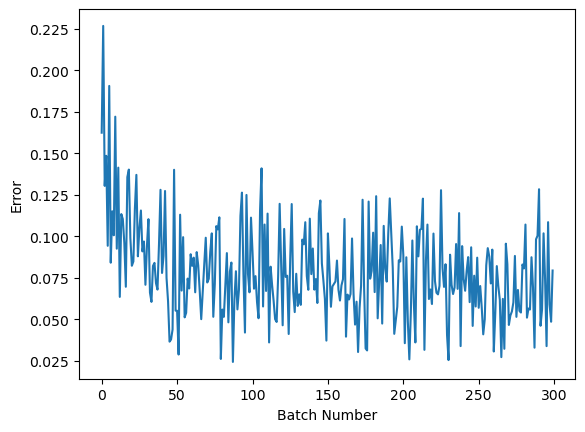

In [21]:
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

What is the final weight matrix $W$ after training?


In [22]:
print(W.numpy()) # a weight matrix of shape (50,784)

[[-0.33999994 -0.30999997 -0.29       ... -0.23000003 -0.4799998
  -0.58999974]
 [-0.36999992 -0.28       -0.30999997 ... -0.26000002 -0.43999985
  -0.6299997 ]
 [-0.31999996 -0.25000003 -0.32999995 ... -0.31999996 -0.45999983
  -0.65999967]
 ...
 [-0.34999993 -0.23000003 -0.33999994 ... -0.23000003 -0.5199998
  -0.5199998 ]
 [-0.3999999  -0.26000002 -0.28       ... -0.34999993 -0.45999983
  -0.6199997 ]
 [-0.33999994 -0.24000004 -0.36999992 ... -0.27       -0.4899998
  -0.6299997 ]]


<a id="ref5"></a>
<h3>Learned features</h3> 


We can take each hidden unit and visualize the connections between that hidden unit and each element in the input vector. In our case, we have 50 hidden units. Lets visualize those.


Let's plot the current weights:
<b>tile_raster_images</b> helps in generating an easy to grasp image from a set of samples or weights. It transforms the <b>uw</b> (with one flattened image per row of size 784), into an array (of size $28\times28$) in which images are reshaped and laid out like tiles on a floor.


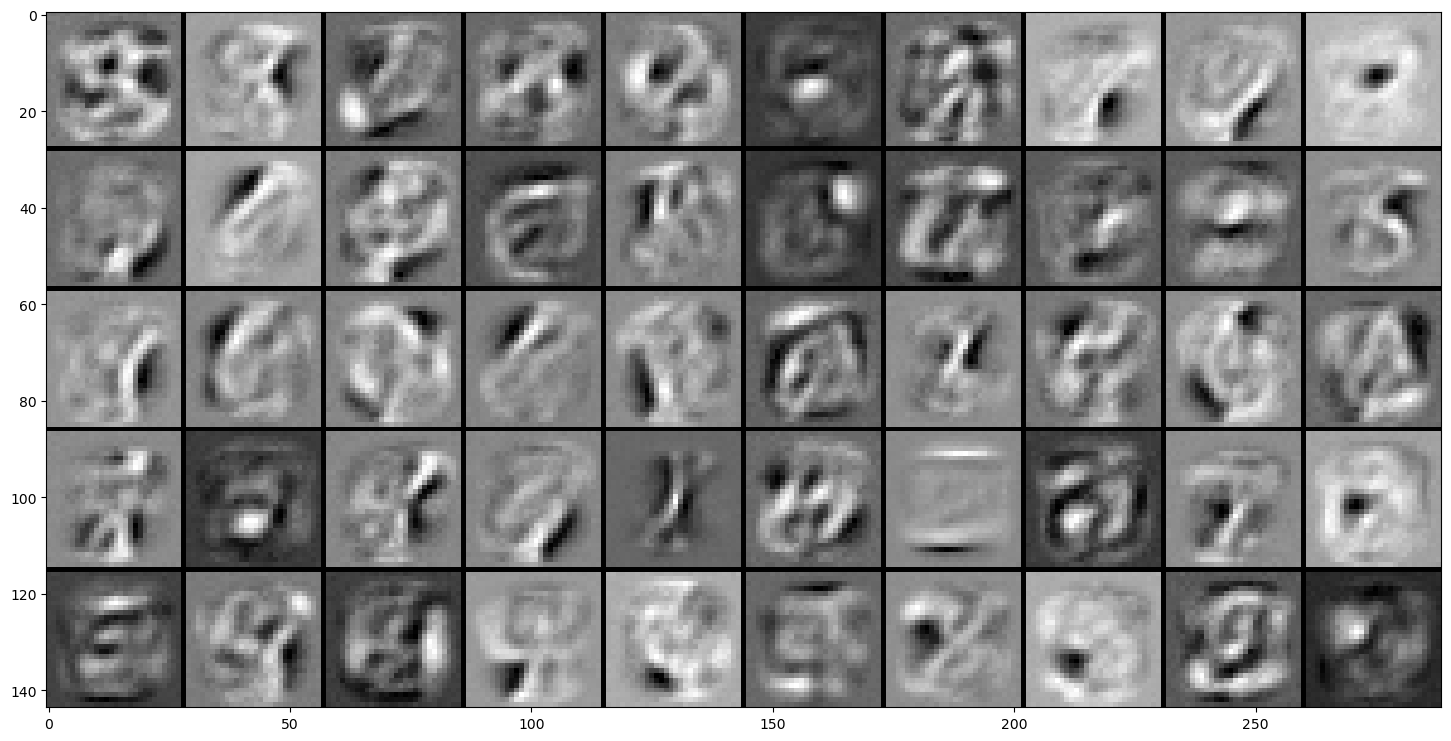

In [23]:
tile_raster_images(X=W.numpy().T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=W.numpy().T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Each tile in the above visualization corresponds to a vector of connections between a hidden unit and visible layer's units. 


Let's look at one of the learned weights corresponding to one of hidden units for example. In this particular square, the gray color represents weight = 0, and the whiter it is, the more positive the weights are (closer to 1). Conversely, the darker pixels are, the more negative the weights. The positive pixels will increase the probability of activation in hidden units (after multiplying by input/visible pixels), and negative pixels will decrease the probability of a unit hidden to be 1 (activated). So, why is this important?  So we can see that this specific square (hidden unit) can detect a feature (e.g. a "/" shape) and if it exists in the input.


In [ ]:
from PIL import Image
image = Image.fromarray(tile_raster_images(X =W.numpy().T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Let's look at the reconstruction of an image now. Imagine that we have a destructed image of figure 3. Lets see if our trained network can fix it:

First we plot the image:


In [ ]:
!wget -O destructed3.jpg  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
img = Image.open('destructed3.jpg')
img

Now let's pass this image through the neural net:


In [ ]:
# convert the image to a 1d numpy array
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0

sample_case = tf.cast(sample_case, dtype=tf.float32)

Feed the sample case into the network and reconstruct the output:


In [ ]:
hh0_p = tf.nn.sigmoid(tf.matmul(sample_case, W) + hb)
hh0_s = tf.round(hh0_p)

print("Probability nodes in hidden layer:" ,hh0_p)
print("activated nodes in hidden layer:" ,hh0_s)

# reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s, tf.transpose(W)) + vb)

print(vv1_p)
#rec_prob = sess.run(vv1_p, feed_dict={ hh0_s: hh0_s_val, W: prv_w, vb: prv_vb})

Here we plot the reconstructed image:


In [ ]:
img = Image.fromarray(tile_raster_images(X=vv1_p.numpy(), img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 

<hr>

## Want to learn more?

Also, you can use __Watson Studio__ to run these notebooks faster with bigger datasets.__Watson Studio__ is IBM’s leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, __Watson Studio__ enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of __Watson Studio__ users today with a free account at [Watson Studio](https://cocl.us/ML0120EN_DSX).This is the end of this lesson. Thank you for reading this notebook, and good luck on your studies.


### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>

Updated to TF 2.X by  <a href="https://ca.linkedin.com/in/nilmeier"> Jerome Nilmeier</a><br />


### References:
https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine  
http://deeplearning.net/tutorial/rbm.html  
http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf<br>
http://imonad.com/rbm/restricted-boltzmann-machine/  


<hr>

Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).
